In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader


import os


import warnings
warnings.filterwarnings("ignore")

import cv2
import requests
from PIL import Image


from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [2]:
data_dir = "/home/ltarricone/ml4h_data/project1/chest_xray/chest_xray"

In [3]:
class PneumoniaModelBase(nn.Module):
    """
    Base class that will have all the useful methods for the training of the model
    """
    
    # this is for loading the batch of train image and outputting its loss, accuracy 
    # & predictions
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels, weight=weight)      # weighted compute loss
        acc,preds = accuracy(out, labels)                       # calculate accuracy
        
        return {'train_loss': loss, 'train_acc':acc}
       
    # this is for computing the train average loss and acc for each epoch
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['train_acc'] for x in outputs]          # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    # this is for loading the batch of val/test image and outputting its loss, accuracy, 
    # predictions & labels
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels)                     # compute loss
        acc,preds = accuracy(out, labels)                       # calculate acc & get preds
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    # detach extracts only the needed number, or other numbers will crowd memory
    
    # this is for computing the validation average loss and acc for each epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]            # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # this is for printing out the results after each epoch
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
    
    # this is for using on the test set, it outputs the average loss and acc, 
    # and outputs the predictions
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}  


class PneumoniaResnet(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        return self.network(xb)

In [4]:
# this is for loading the model from a previously saved one

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = True

    model.eval()
    return model

model = load_checkpoint('./PneumoniaResnet.pth')
model.to('cpu')

PneumoniaResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

I arrived here pt.0
torch.Size([3, 224, 224])


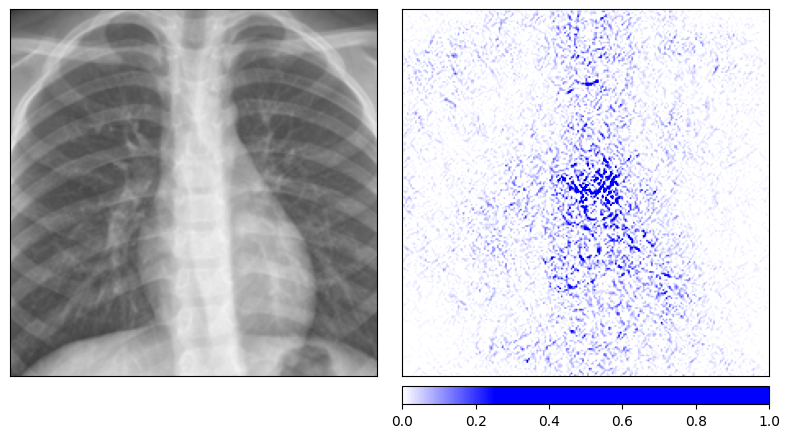

torch.Size([3, 224, 224])


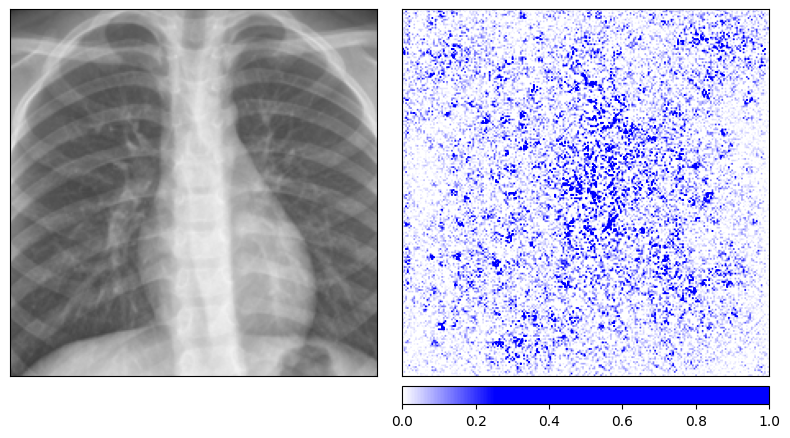

torch.Size([3, 224, 224])


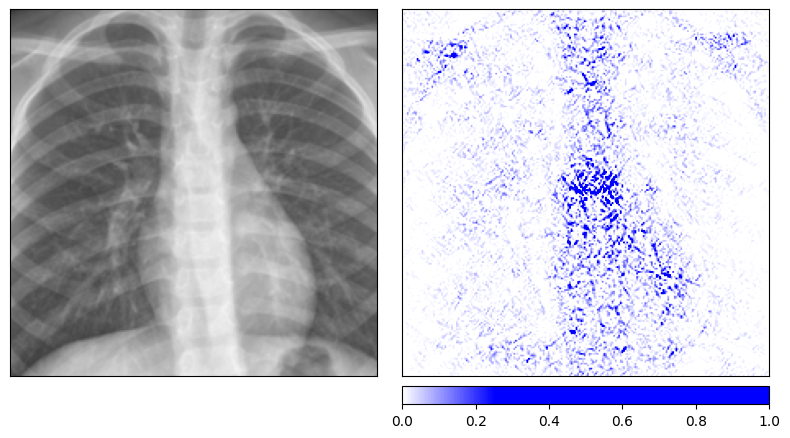

torch.Size([3, 224, 224])


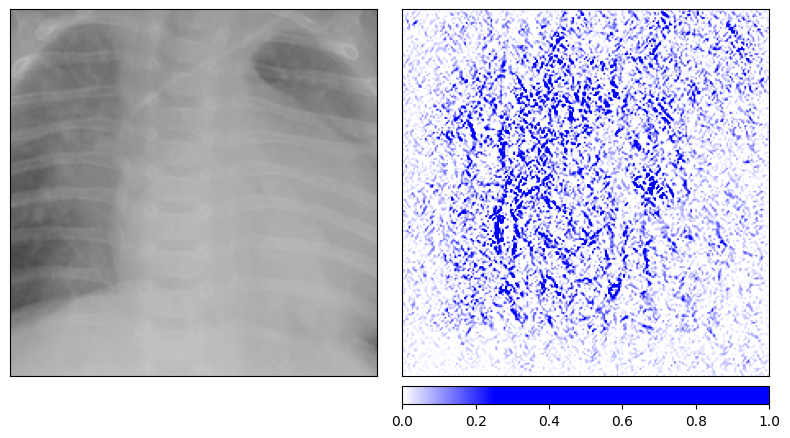

torch.Size([3, 224, 224])


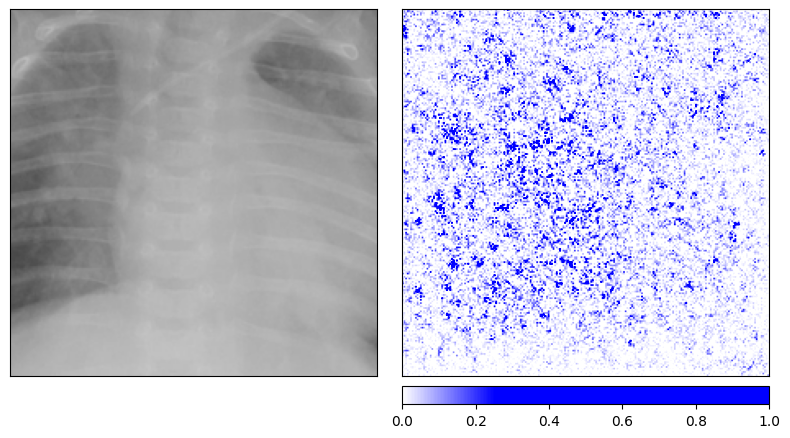

torch.Size([3, 224, 224])


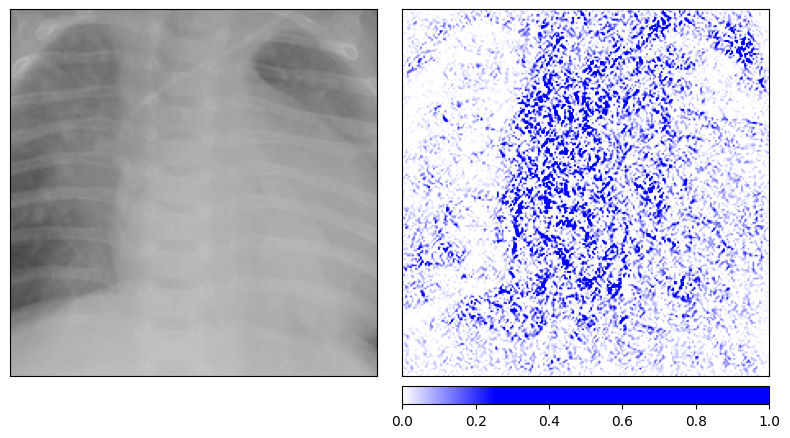

torch.Size([3, 224, 224])


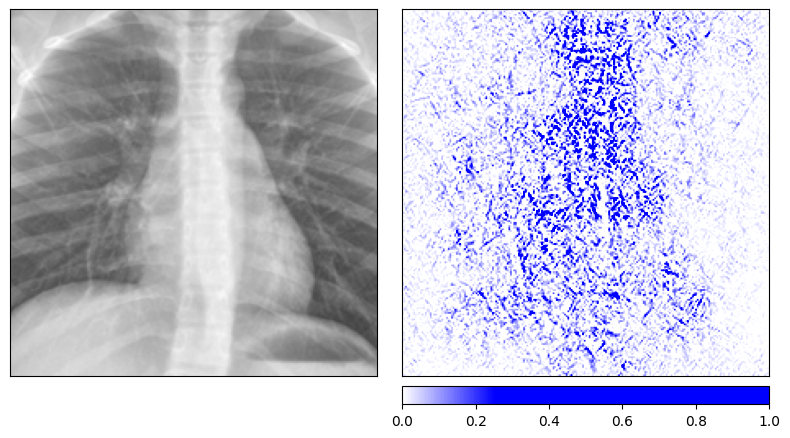

torch.Size([3, 224, 224])


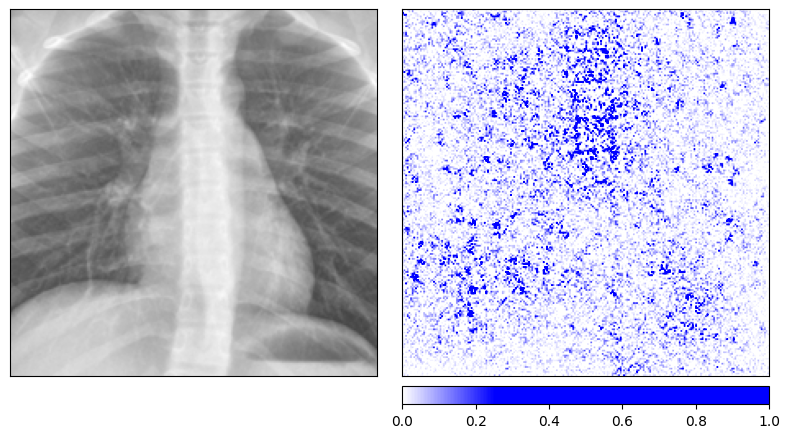

torch.Size([3, 224, 224])


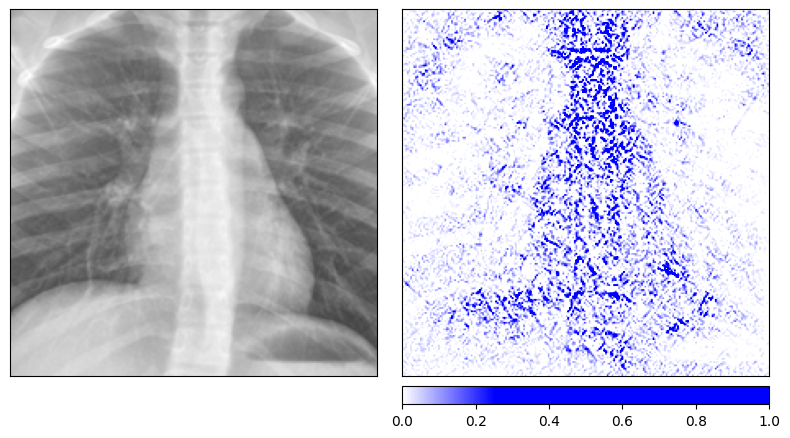

torch.Size([3, 224, 224])


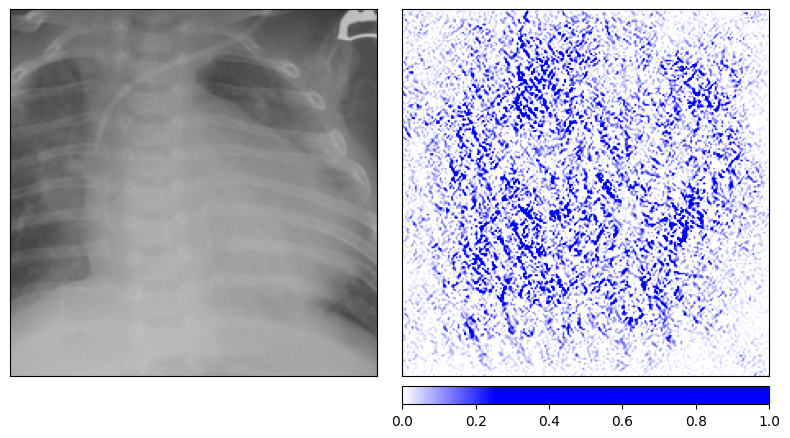

torch.Size([3, 224, 224])


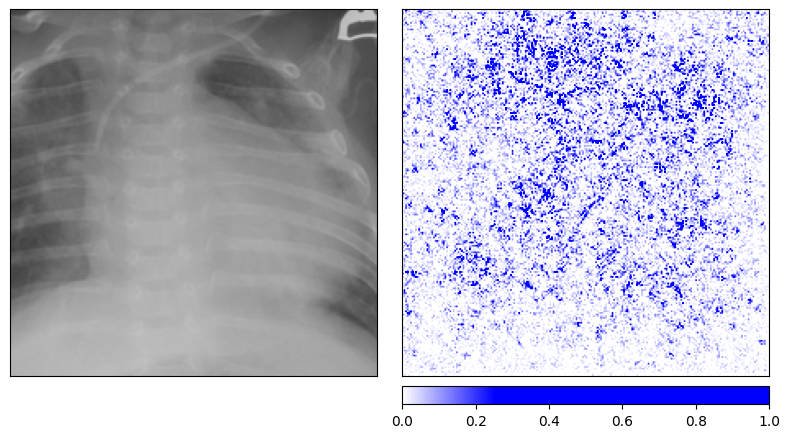

torch.Size([3, 224, 224])


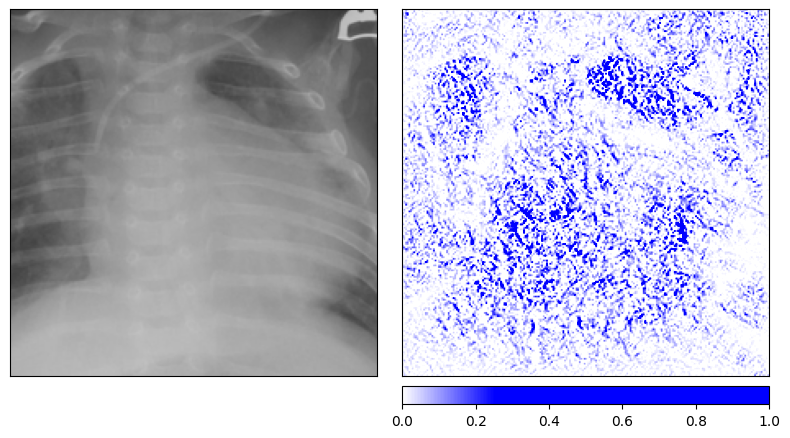

torch.Size([3, 224, 224])


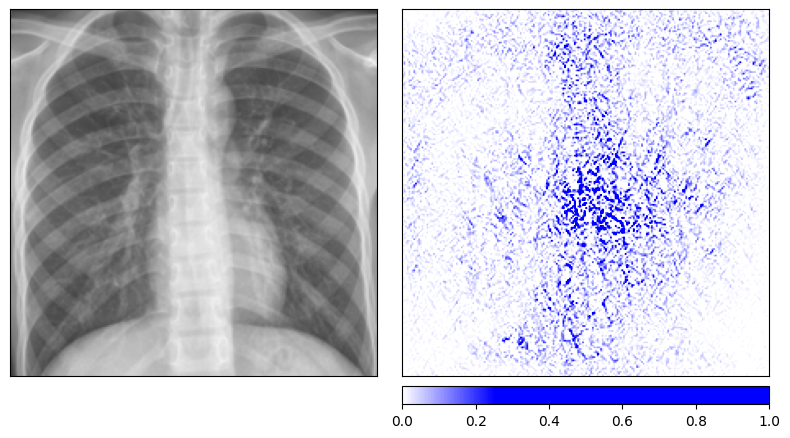

torch.Size([3, 224, 224])


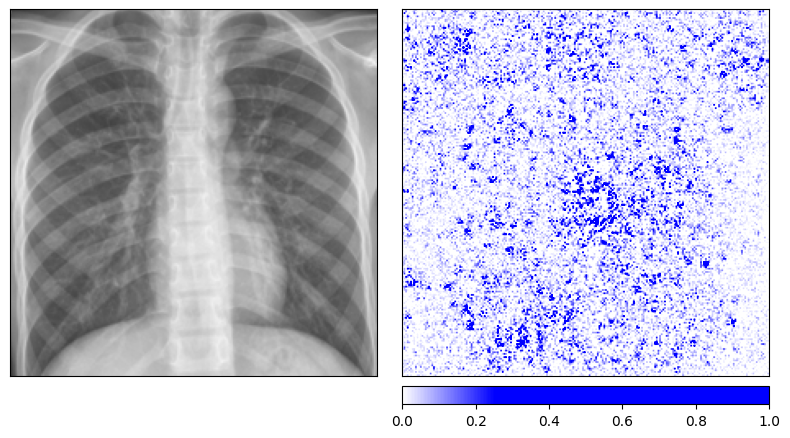

torch.Size([3, 224, 224])


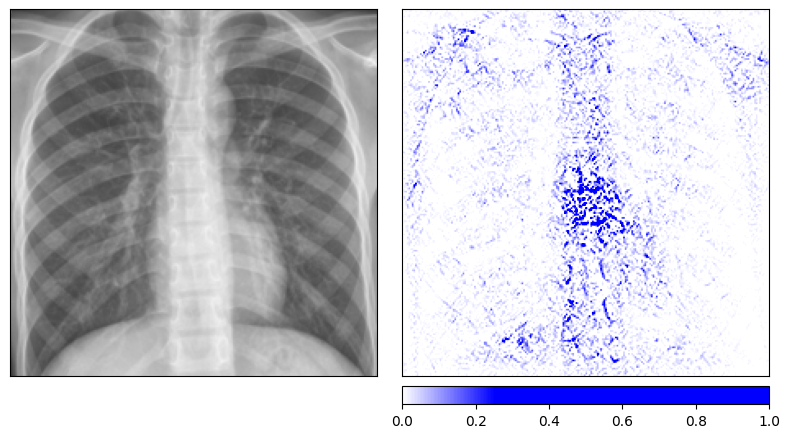

torch.Size([3, 224, 224])


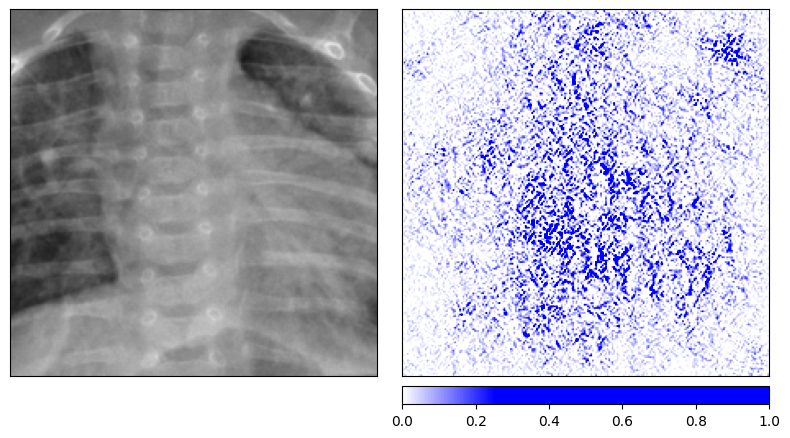

torch.Size([3, 224, 224])


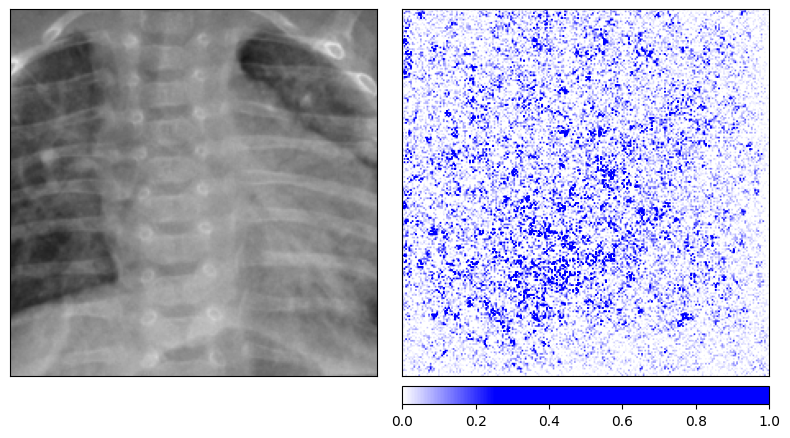

torch.Size([3, 224, 224])


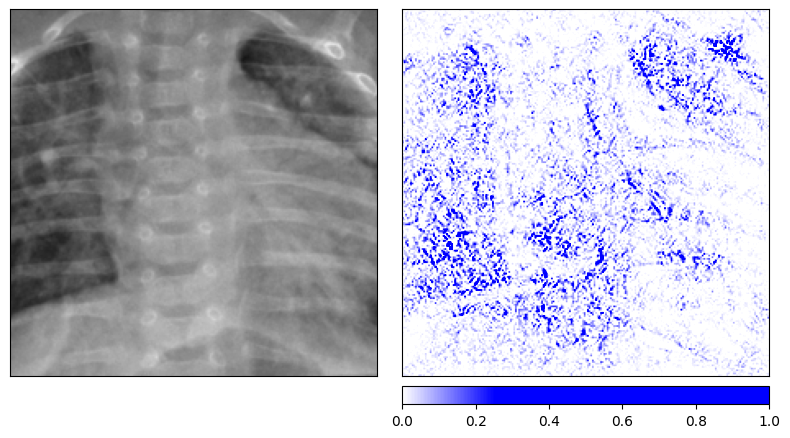

torch.Size([3, 224, 224])


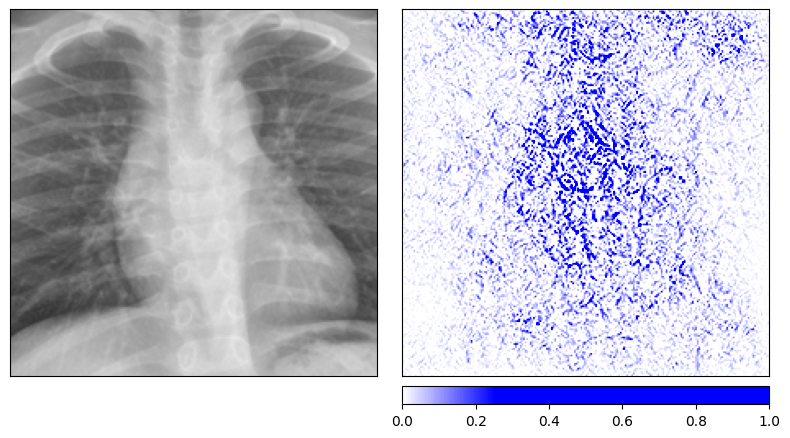

torch.Size([3, 224, 224])


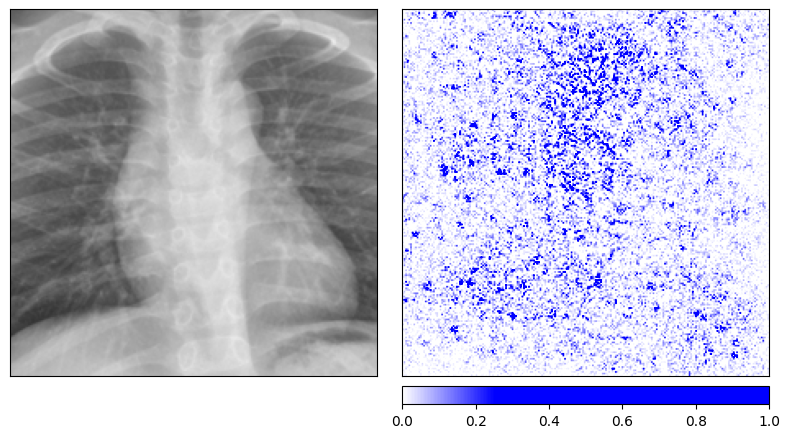

torch.Size([3, 224, 224])


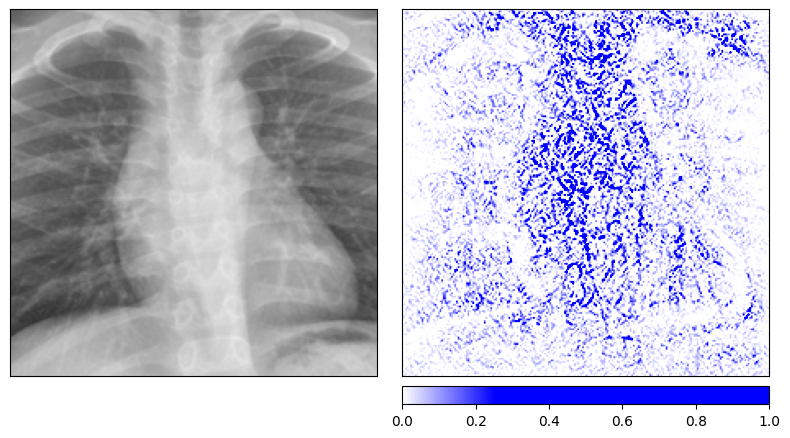

torch.Size([3, 224, 224])


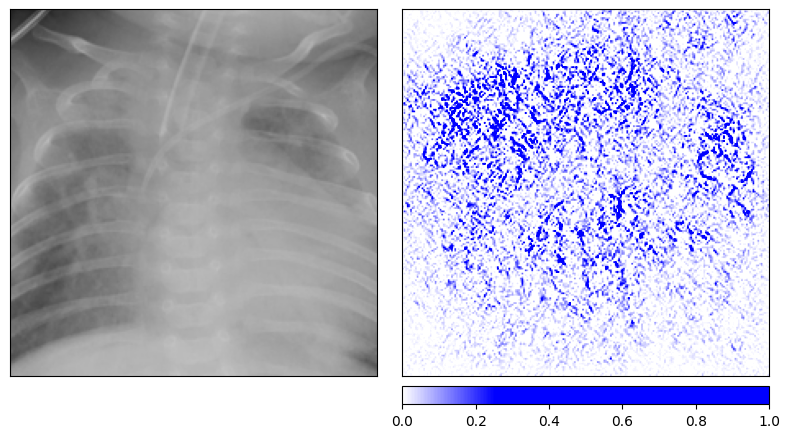

torch.Size([3, 224, 224])


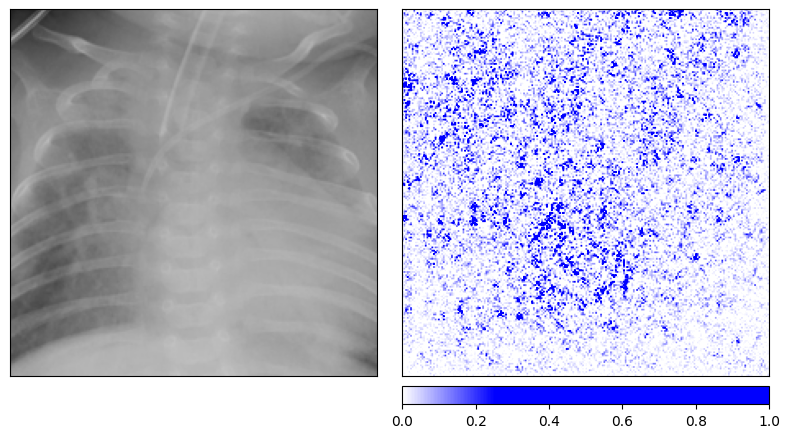

torch.Size([3, 224, 224])


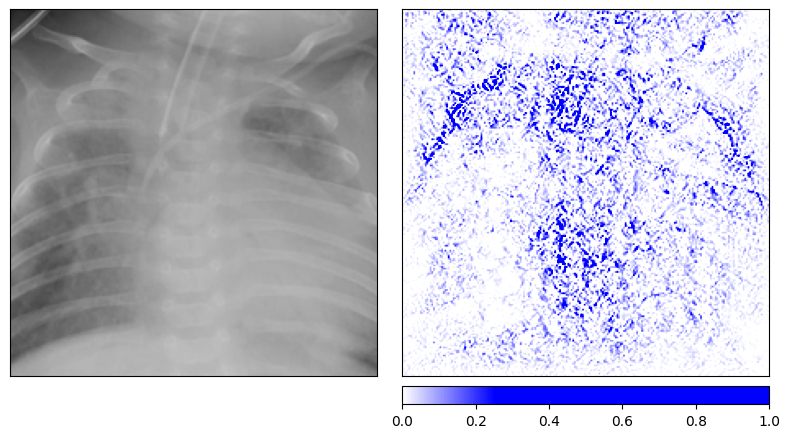

torch.Size([3, 224, 224])


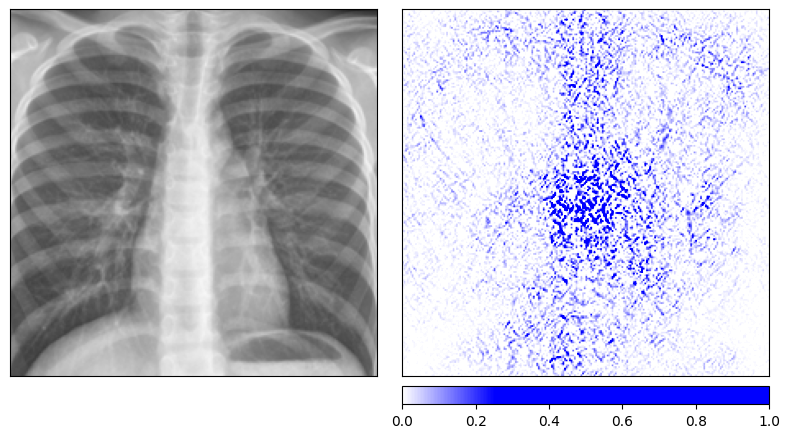

torch.Size([3, 224, 224])


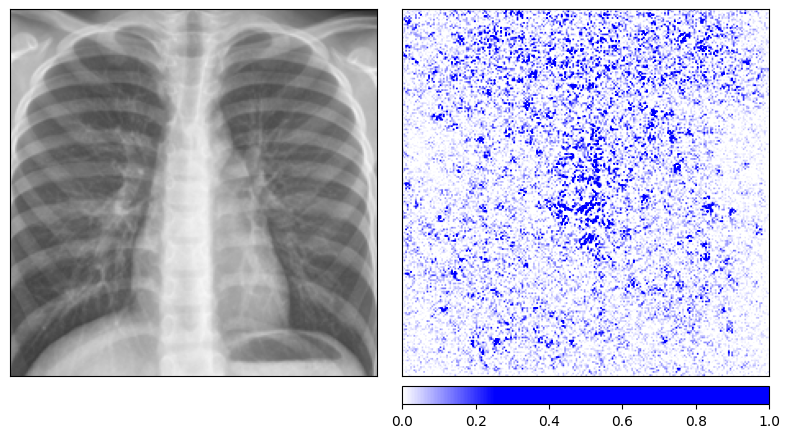

torch.Size([3, 224, 224])


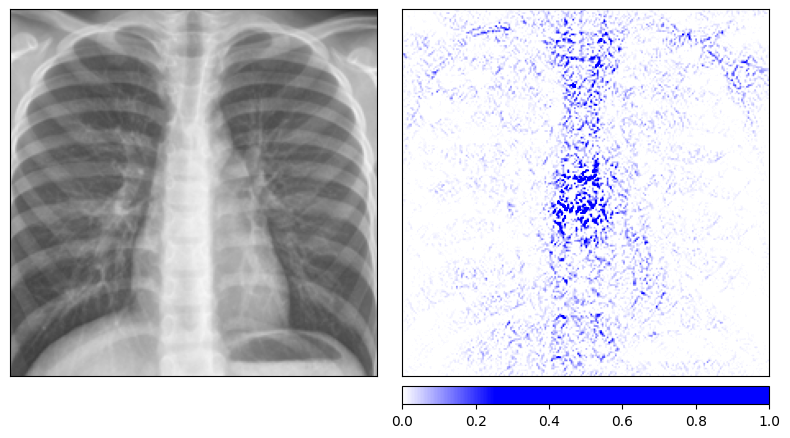

torch.Size([3, 224, 224])


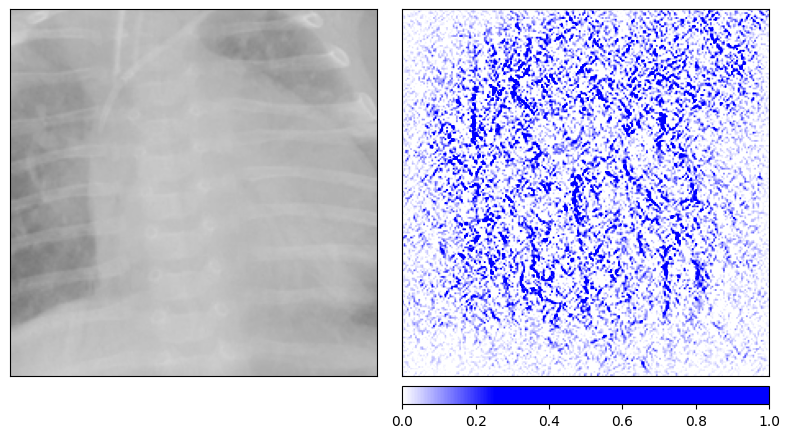

torch.Size([3, 224, 224])


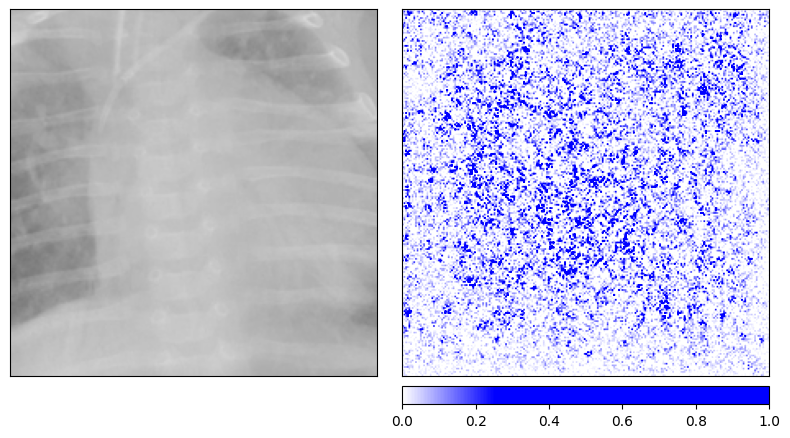

torch.Size([3, 224, 224])


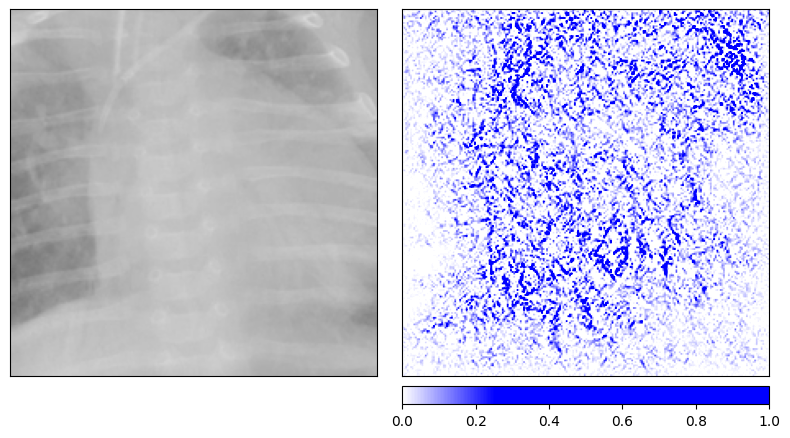

In [7]:
def calculate_integrated_gradients(img_path, model, result_path, baseline_type='zero'):
    img=Image.open(img_path)
    
    
    transform_input = T.Compose([T.Resize(260), T.CenterCrop(224) , T.ToTensor()])
    input_img = transform_input(img)

    input_img = torch.cat([input_img,input_img,input_img], axis = 0)

    input_img = input_img.unsqueeze(0) #add a dimnesion for the steps
    #print("input dim", input.size())
    
    model.eval()
    model.to('cpu')

    # Select baseline based on type
    if baseline_type == 'zero':
        baseline = torch.zeros_like(input_img)
    elif baseline_type == 'random':
        baseline = torch.rand_like(input_img)  # Random noise baseline
    elif baseline_type == 'mean':
        baseline = torch.full_like(input_img, 0.5)  # Mid-value baseline

    integrated_gradients = IntegratedGradients(model)
    attributions_ig = integrated_gradients.attribute(input_img, baselines=baseline, target=0, n_steps=6)
    
    default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                         [(0, '#ffffff'),
                                                          (0.25, '#0000ff'),
                                                          (1, '#0000ff')], N=256)
    
    np_attributions_ig=attributions_ig.squeeze(0).cpu().detach().numpy()
    np_transformed_img=input_img.squeeze(0).cpu().detach().numpy()


    fig, ax = viz.visualize_image_attr_multiple(np.transpose(np_attributions_ig, (1, 2, 0)),
                                              np.transpose(np_transformed_img, (1, 2, 0)),
                                              ["original_image", "heat_map"],
                                              ["all", "positive"],
                                              cmap=default_cmap,
                                              show_colorbar=True)
    
    # fig.savefig(result_path)

baselines = ['zero', 'random', 'mean']

# nomral_test_dir = 'ml4h_data/project1/chest_xray/chest_xray/test/NORMAL'
# pneumonia_test_dir = 'ml4h_data/project1/chest_xray/chest_xray/test/PNEUMONIA'


# Select the paths of the first 5 elements
normal_paths = ['ml4h_data/project1/chest_xray/test/NORMAL/IM-0001-0001.jpeg',
                'ml4h_data/project1/chest_xray/test/NORMAL/IM-0003-0001.jpeg',
                'ml4h_data/project1/chest_xray/test/NORMAL/IM-0005-0001.jpeg',
                'ml4h_data/project1/chest_xray/test/NORMAL/IM-0006-0001.jpeg',
                'ml4h_data/project1/chest_xray/test/NORMAL/IM-0007-0001.jpeg'
               ]
pneumonia_paths = ['ml4h_data/project1/chest_xray/test/PNEUMONIA/person1_virus_11.jpeg',
                   'ml4h_data/project1/chest_xray/test/PNEUMONIA/person1_virus_12.jpeg',
                   'ml4h_data/project1/chest_xray/test/PNEUMONIA/person1_virus_13.jpeg',
                   'ml4h_data/project1/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg',
                   'ml4h_data/project1/chest_xray/test/PNEUMONIA/person1_virus_7.jpeg'
                  ]


for i in range(5):
    
    #make sure you have a folder Q3 created
    for baseline in baselines:
        
        #  For Normal       
        calculate_integrated_gradients(normal_paths[i], model, f'/Q3/normal-attributionmap{i}_{baseline}.png', baseline_type= baseline)
    for baseline in baselines:
        # For Pneumonia
        calculate_integrated_gradients(pneumonia_paths[i], model, f'/Q3/pneumonia-attributionmap{i}_{baseline}.png', baseline_type= baseline)